In [9]:
import os, glob, h5py, gc, json, math, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Config
# -----------------------------
DATA_DIR = "/kaggle/input/figshare-brain-tumor-dataset/dataset/data"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42
CLASS_MAP = {1: "meningioma", 2: "glioma", 3: "pituitary"}
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Helpers
# -----------------------------
def load_one_mat_h5(path):
    """
    Load a single v7.3 .mat (HDF5) file and return (image_2d, label_int).
    Expects keys under cjdata: 'image' (2D), 'label' (scalar 1/2/3).
    """
    with h5py.File(path, 'r') as f:
        image = np.array(f['cjdata']['image']).T
        raw_label = np.array(f['cjdata']['label'])
        label = int(np.squeeze(raw_label).astype(np.int64))
    return image, label

def preprocess_image_to_resnet(x2d, target=IMG_SIZE):
    """
    Per-image min-max normalize to [0,1], resize, and expand gray -> RGB.
    Returns float32 (H, W, 3).
    """
    x = x2d.astype(np.float32)
    x_min, x_max = np.min(x), np.max(x)
    if x_max > x_min:
        x = (x - x_min) / (x_max - x_min)
    else:
        x = np.zeros_like(x, dtype=np.float32)
    x = tf.image.resize(x[..., None], (target, target)).numpy()
    x = np.repeat(x, 3, axis=-1)
    return x

def make_tf_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# -----------------------------
# Load all .mat files
# -----------------------------
mat_files = sorted([os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".mat")])
print(f"Found .mat files: {len(mat_files)}")
X_list, y_list = [], []
for i, fpath in enumerate(mat_files):
    try:
        img2d, label = load_one_mat_h5(fpath)
        if label not in CLASS_MAP:
            continue
        X_list.append(img2d)
        y_list.append(label)
    except Exception as e:
        print(f"[WARN] Skipping {os.path.basename(fpath)} due to: {e}")
print("Loaded slices:", len(X_list))
assert len(X_list) > 0, "No images loaded. Check DATA_DIR and file structure."

# -----------------------------
# Preprocess -> arrays
# -----------------------------
X = np.array([preprocess_image_to_resnet(x) for x in X_list], dtype=np.float32)
y_raw = np.array(y_list, dtype=np.int64)
y = to_categorical(y_raw - 1, num_classes=3)
print("X shape:", X.shape, "y shape:", y.shape)
print("Label distribution (1=meningioma,2=glioma,3=pituitary):",
      {k: int(np.sum(y_raw == k)) for k in sorted(CLASS_MAP.keys())})

# -----------------------------
# Train/Val split
# -----------------------------
X_train, X_val, y_train, y_val, y_raw_train, y_raw_val = train_test_split(
    X, y, y_raw, test_size=0.2, random_state=SEED, stratify=y_raw
)
print("Train:", X_train.shape, "Val:", X_val.shape)
train_ds = make_tf_dataset(X_train, y_train, shuffle=True)
val_ds = make_tf_dataset(X_val, y_val, shuffle=False)

# -----------------------------
# Build ResNet50 (FROM SCRATCH)
# -----------------------------
base = ResNet50(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(3, activation='softmax')(x)
model = Model(inputs=base.input, outputs=out)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# -----------------------------
# Callbacks (No EarlyStopping)
# -----------------------------
ckpt_path = "/kaggle/working/resnet50_brain_tumor_from_scratch.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy",
                                       save_best_only=True, mode="max", verbose=1)
]

# -----------------------------
# Train (Always for all epochs)
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# Evaluate
# -----------------------------
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")

# -----------------------------
# Confusion Matrix + Report
# -----------------------------
y_val_pred_prob = model.predict(val_ds, verbose=0)
y_val_pred_idx = np.argmax(y_val_pred_prob, axis=1)
y_val_true_idx = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_true_idx, y_val_pred_idx)
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)
print("\nClassification Report:\n",
      classification_report(y_val_true_idx, y_val_pred_idx,
                            target_names=[CLASS_MAP[1], CLASS_MAP, CLASS_MAP]))

# -----------------------------
# Plots
# -----------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', []), label='Train Acc')
plt.plot(history.history.get('val_accuracy', []), label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history.get('loss', []), label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# -----------------------------
# Save final model
# -----------------------------


Found .mat files: 3064
Loaded slices: 3064
X shape: (3064, 224, 224, 3) y shape: (3064, 3)
Label distribution (1=meningioma,2=glioma,3=pituitary): {1: 708, 2: 1426, 3: 930}
Train: (2451, 224, 224, 3) Val: (613, 224, 224, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 24,585,219 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5302 - loss: 1.3011
Epoch 1: val_accuracy improved from -inf to 0.46493, saving model to /kaggle/working/resnet50_brain_tumor_from_scratch.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 103s 485ms/step - accuracy: 0.5311 - loss: 1.2974 - val_accuracy: 0.4649 - val_loss: 1.7606
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7285 - loss: 0.6258
Epoch 2: val_accuracy did not improve from 0.46493
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.7286 - loss: 0.6254 - val_accuracy: 0.4649 - val_loss: 2.6850
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7684 - loss: 0.5319
Epoch 3: val_accuracy did not improve from 0.46493
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.7685 - loss: 0.5318 - val_accuracy: 0.2382 - val_loss: 1.1725
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8389 - loss: 0.4092
Epoch 4: val_accuracy did not improve from 0.46493
77/77 ━━━━━━━━━━━━━━━━━

TypeError: unsupported format string passed to dict.__format__


Overall Accuracy: 0.6754

Confusion Matrix (rows=true, cols=pred):
 [[142   0   0]
 [115 170   0]
 [ 84   0 102]]


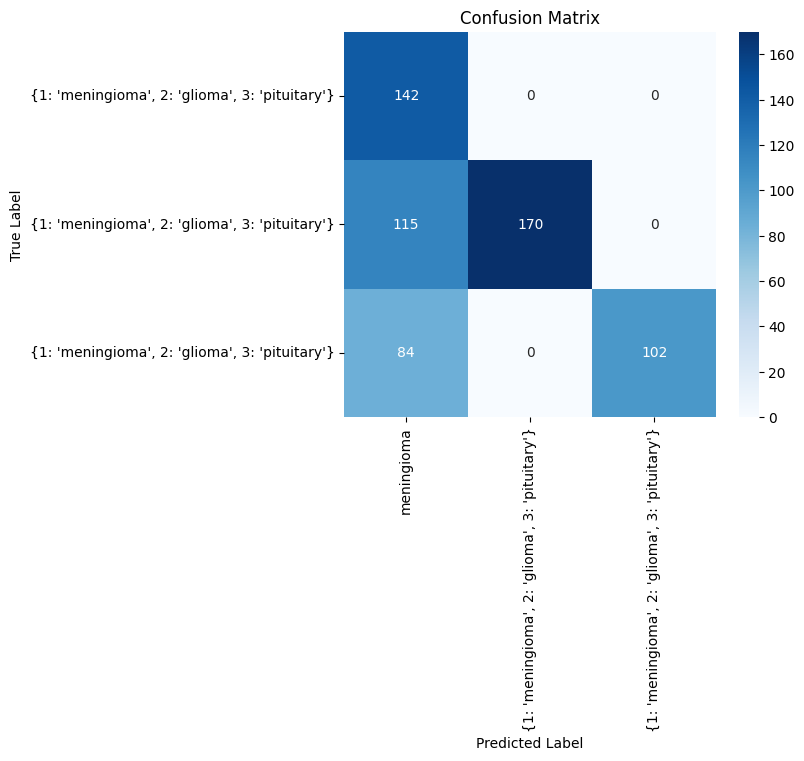

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# After model evaluation and prediction:

# Predict class indices on validation dataset
y_val_pred_prob = model.predict(val_ds, verbose=0)
y_val_pred_idx = np.argmax(y_val_pred_prob, axis=1)
y_val_true_idx = np.argmax(y_val, axis=1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_val_true_idx, y_val_pred_idx)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_val_true_idx, y_val_pred_idx)
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)

# Optional: visualize confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[CLASS_MAP[1], CLASS_MAP, CLASS_MAP],
            yticklabels=[CLASS_MAP, CLASS_MAP, CLASS_MAP])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
